# Introduction

The data is a collection of all the lines from all the harry potter books sourced from [gastonstat on github](https://github.com/gastonstat/harry-potter-data). Each row in the original data is a set of words, most likely lines on the page, with columns for the text (string), book (string), and chapter (string). Since all the columns are strings I'll create other columns with statistics about the sentences for clustering analysis.

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk

In [86]:
harry = pd.read_csv('harry_potter_books.csv')
harry.head()

,text,book,chapter
0,"THE BOY WHO LIVED Mr. and Mrs. Dursley, of nu...",Book 1: Philosopher's Stone,chap-1
1,"four, Privet Drive, were proud to say that the...",Book 1: Philosopher's Stone,chap-1
2,thank you very much. They were the last people...,Book 1: Philosopher's Stone,chap-1
3,"be involved in anything strange or mysterious,...",Book 1: Philosopher's Stone,chap-1
4,with such nonsense. Mr. Dursley was the direc...,Book 1: Philosopher's Stone,chap-1


Each row contains some `text` (probably just the literal lines from whatever ebook this guy scraped the text from) and also notes the `book` it is from and what `chapter` the text is from as well. Let's make a new column that is the number of words in each row using a very, very tasty library called NLTK.

In [87]:
harry['word count'] = harry['text'].apply(lambda x: len(nltk.word_tokenize(x)))
harry['word count'].head()

0    11
1    15
2    14
3    14
4    12
Name: word count, dtype: int64

To get the clustering party started I'll first merge every 4 rows together so that there is more info per row (and since there's so many rows this will not hurt the sample size too much). 

This is not trivial! I will group them into individual chapters and then re-split them. I'll also only take chapters 3 and 4 to save on training time.

In [88]:
combined_rows = harry.groupby(['book', 'chapter']).agg({'text': ' '.join, 'word count': 'sum'}).reset_index()
combined_rows = combined_rows.loc[(combined_rows['book'] == 'Book 3: Prisoner of Azkaban') | (combined_rows['book'] == 'Book 4: Goblet of Fire')]
combined_rows.head()

,book,chapter,text,word count
36,Book 3: Prisoner of Azkaban,chap-1,OWL POST Harry Potter was a highly unusual ...,4349
37,Book 3: Prisoner of Azkaban,chap-10,THE MARAUDER'S MAP Madam Pomfrey insisted o...,8973
38,Book 3: Prisoner of Azkaban,chap-11,THE FIREBOLT Harry didn't have a very clear...,6553
39,Book 3: Prisoner of Azkaban,chap-12,THE PATRONUS Harry knew that Hermione had m...,6230
40,Book 3: Prisoner of Azkaban,chap-13,GRYFFINDOR VERSUS RAVENCLAW It looked like ...,5398


Seeing how many words are in each row its clear we have a row per chapter. Now to let NLTK do the sentence splitting magic and EXPLODE the rows into their own rows.

In [89]:
combined_rows['text'] = combined_rows['text'].apply(lambda x: nltk.sent_tokenize(x))
sentences = combined_rows.explode('text').drop('word count', axis=1)
sentences.head()

,book,chapter,text
36,Book 3: Prisoner of Azkaban,chap-1,OWL POST Harry Potter was a highly unusual ...
36,Book 3: Prisoner of Azkaban,chap-1,"For one thing, he hated the summer holidays mo..."
36,Book 3: Prisoner of Azkaban,chap-1,"For another, he really wanted to do his homewo..."
36,Book 3: Prisoner of Azkaban,chap-1,And he also happened to be a wizard.
36,Book 3: Prisoner of Azkaban,chap-1,"It was nearly midnight, and he was lying on hi..."


In [90]:
sentences.describe()

,book,chapter,text
count,20630,20630,20630
unique,2,37,18399
top,Book 4: Goblet of Fire,chap-9,.
freq,14010,905,2048


It's a little annoying that NLTK thinks a solid number of sentences are a single period so I'll remove all those rows just in case they ruin my clustering later. (there are some other annoyingly short sentences I removed too)

In [91]:
sentences = sentences.loc[(sentences['text'] != '.') & (sentences['text'] != ".'") & (sentences['text'] != "...")]
sentences.describe()

,book,chapter,text
count,18544,18544,18544
unique,2,37,18396
top,Book 4: Goblet of Fire,chap-21,Clunk.
freq,11925,851,9


Now I'll use some useful tools from NLTK to make columns to use when clustering

In [92]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

sentences['word_count'] = sentences['text'].apply(lambda x: len(word_tokenize(x)))
sentences['avg_word_length'] = sentences['text'].apply(lambda x: sum(len(word) for word in word_tokenize(x)) / len(word_tokenize(x)))
sentences['stopwords_count'] = sentences['text'].apply(lambda x: len([word for word in word_tokenize(x) if word.lower() in stop_words]))
sentences['sentence_length'] = sentences['text'].apply(lambda x: len(x.split()))

import string
sentences['punctuation_count'] = sentences['text'].apply(lambda x: len([char for char in x if char in string.punctuation]))

In [93]:
sentences.head()

,book,chapter,text,word_count,avg_word_length,stopwords_count,sentence_length,punctuation_count
36,Book 3: Prisoner of Azkaban,chap-1,OWL POST Harry Potter was a highly unusual ...,13,3.769231,3,12,1
36,Book 3: Prisoner of Azkaban,chap-1,"For one thing, he hated the summer holidays mo...",17,3.705882,8,15,2
36,Book 3: Prisoner of Azkaban,chap-1,"For another, he really wanted to do his homewo...",25,3.360000,14,22,3
36,Book 3: Prisoner of Azkaban,chap-1,And he also happened to be a wizard.,9,3.222222,5,8,1
36,Book 3: Prisoner of Azkaban,chap-1,"It was nearly midnight, and he was lying on hi...",51,3.941176,21,45,7


Adding a few more columns that also make use of NLTKs cooler features like polarity and named entity count. 

In [94]:
from nltk.sentiment import SentimentIntensityAnalyzer

# sentiment analyzer
sid = SentimentIntensityAnalyzer()

sentences['polarity'] = sentences['text'].apply(lambda x: sid.polarity_scores(x)['compound'] )
sentences['subjectivity_score'] = sentences['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
for tag in ['JJ', 'RB', 'NN', 'VB']:
    sentences[tag + '_count'] = sentences['text'].apply(lambda x: sum(1 for _, pos in nltk.pos_tag(nltk.word_tokenize(x)) if pos == tag))
sentences['named_entity_count'] = sentences['text'].apply(lambda x: sum(1 for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(x))) if hasattr(chunk, 'label')))

The tags 'JJ', 'RB', 'NN', and 'VB' correspond to parts of speech adjective, adverb, noun, and verb.

In [95]:
sentences.reset_index(drop=True, inplace=True)
sentences.head(5)

,book,chapter,text,word_count,avg_word_length,stopwords_count,sentence_length,punctuation_count,polarity,subjectivity_score,JJ_count,RB_count,NN_count,VB_count,named_entity_count
0,Book 3: Prisoner of Azkaban,chap-1,OWL POST Harry Potter was a highly unusual ...,13,3.769231,3,12,1,0.0000,0.0000,2,1,1,0,2
1,Book 3: Prisoner of Azkaban,chap-1,"For one thing, he hated the summer holidays mo...",17,3.705882,8,15,2,-0.3818,-0.3818,1,0,4,0,0
2,Book 3: Prisoner of Azkaban,chap-1,"For another, he really wanted to do his homewo...",25,3.360000,14,22,3,-0.8990,-0.8990,1,1,3,2,0
3,Book 3: Prisoner of Azkaban,chap-1,And he also happened to be a wizard.,9,3.222222,5,8,1,0.0000,0.0000,0,1,1,1,0
4,Book 3: Prisoner of Azkaban,chap-1,"It was nearly midnight, and he was lying on hi...",51,3.941176,21,45,7,0.3182,0.3182,3,2,10,0,2


# Analysis / Results

I'll use standarized colums and consider $n \in (2,3,4,5,6,7)$. I'll also use standard state 51524 because thats todays date if you were wondering.

In [96]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples

X = sentences.drop(['book', 'chapter', 'text' ], axis=1)

In [97]:
ks = [2,3,4,5,6,7]

for k in ks:
    km = make_pipeline(StandardScaler(), KMeans(n_clusters=k, n_init=5, random_state=51524))
    km.fit(X)
    y = km[1].labels_
    sil = silhouette_samples(X, y)
    ARI = adjusted_rand_score(sentences['book'], y)
    print(f'k={k}, silhouette={sil.mean()}, ARI={ARI:.4f}')

k=2, silhouette=0.562870770245955, ARI=-0.0014
k=3, silhouette=0.46884910871205826, ARI=0.0001
k=4, silhouette=0.28087121537651355, ARI=0.0013
k=5, silhouette=0.039228830254121196, ARI=0.0001
k=6, silhouette=0.015277056415322286, ARI=-0.0002
k=7, silhouette=0.01119503912774932, ARI=0.0004


2 is looking like the most delicious number of clusters and also matches up with my question so I'll continue on with $n=2$ and visualize its box plot. 

/Users/kylewodehouse/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


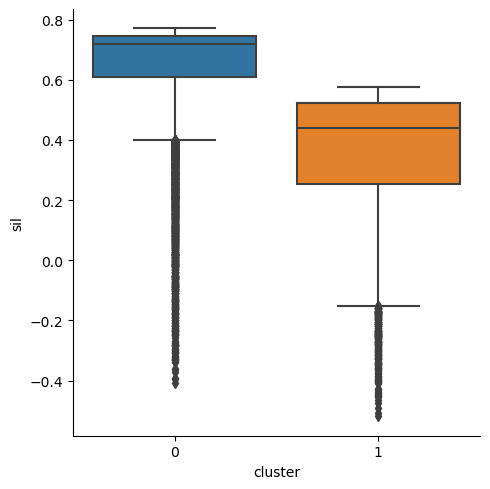

In [98]:
km = make_pipeline(StandardScaler(), KMeans(n_clusters=2, n_init=10, random_state=51524))
km.fit(X)

y = km[1].labels_
sentences["cluster"] = y
sentences["sil"] = silhouette_samples(X, y)
sns.catplot(data=sentences, x="cluster", y="sil", kind="box")

Looks like cluster 0 is decent except for the crazy amount of outliers and cluster 1 is pretty bad. 

Going forward with the agglomerative clustering, I'll only look at $n = {2,3,4}$ since for k-means the other n values were trash and this will save lots of computing time. I'll also standardize X myself so I don't need to mess around with pipelines and not even bother with single-linkage because for all the values of $n$ I tested it made $n-1$ singletons.

In [99]:
from sklearn.cluster import AgglomerativeClustering

for col in X.columns:
    X[col] = StandardScaler().fit_transform(X[[col]])

/Users/kylewodehouse/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/kylewodehouse/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/kylewodehouse/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


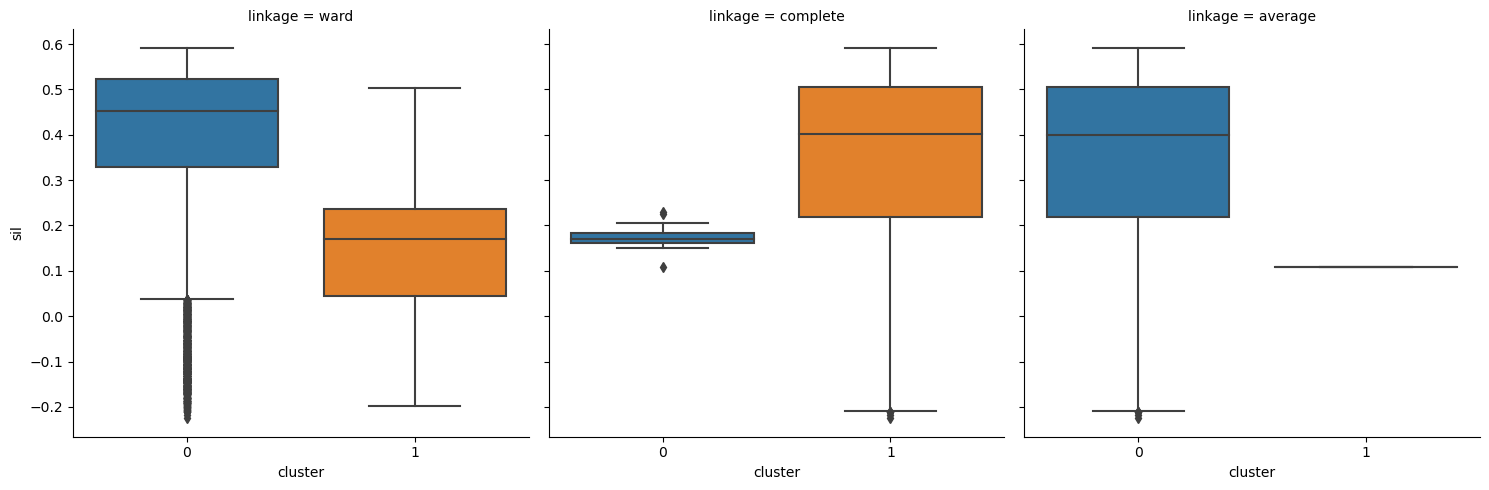

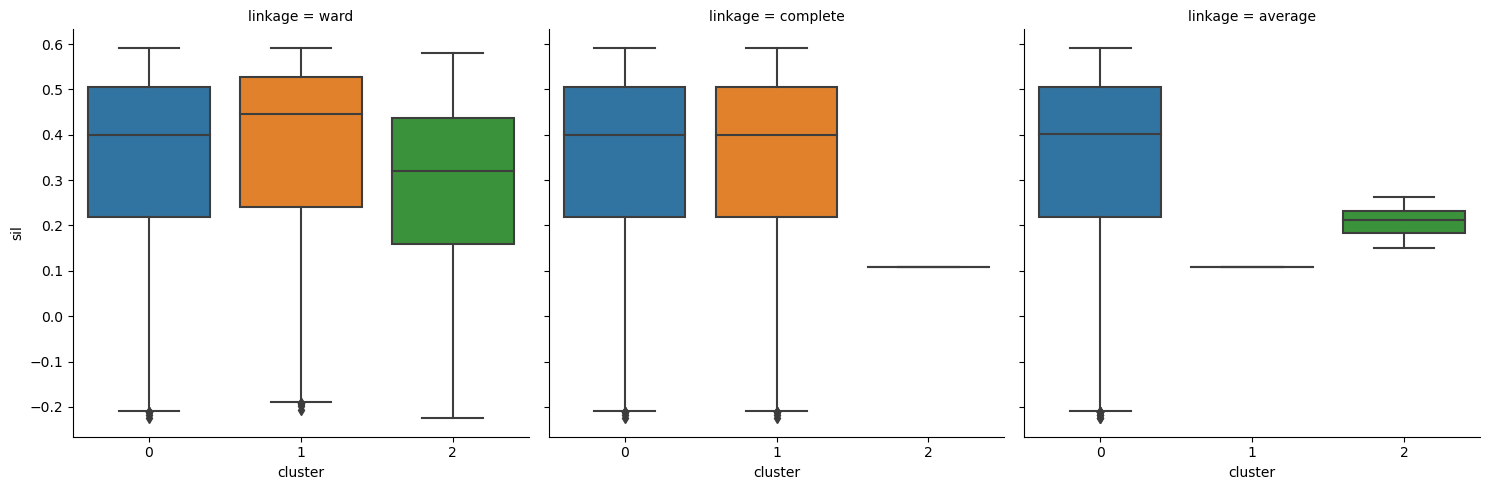

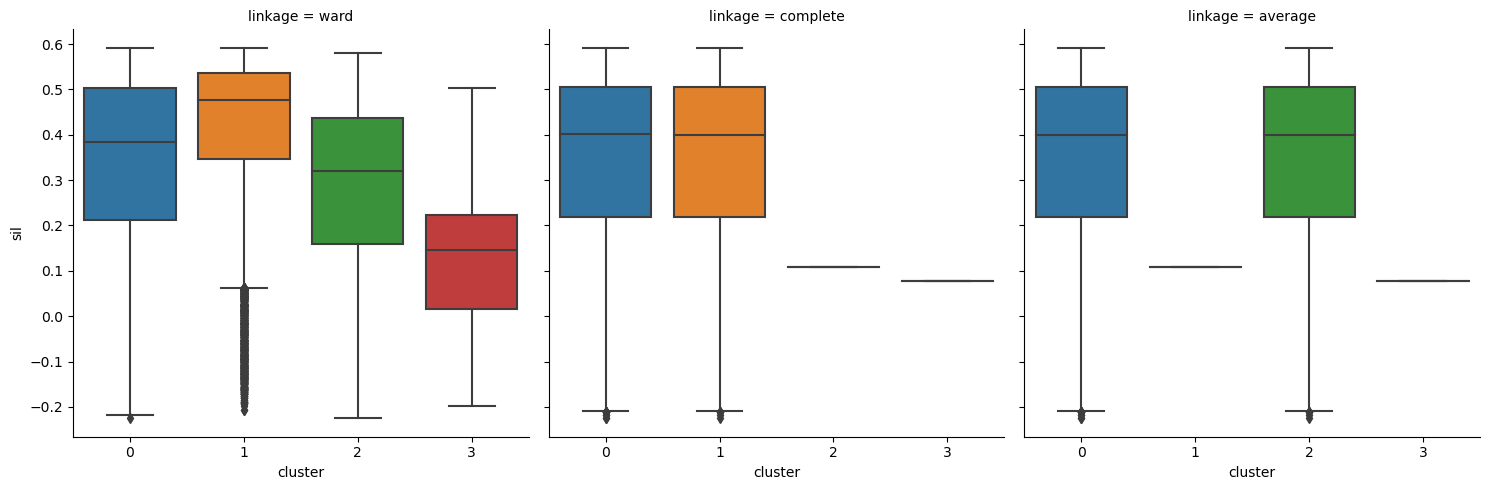

In [100]:
linkages = ["ward", "complete", "average"]

results = pd.DataFrame()

for linkage in linkages:
    data = X.copy()
    agg = AgglomerativeClustering(n_clusters=2, linkage=linkage)
    agg.fit(X)
    data["cluster"] = agg.labels_
    data["sil"] = silhouette_samples(X, y)
    data["linkage"] = linkage
    results = pd.concat( (results, data) )
sns.catplot(data=results, x="cluster", y="sil", col='linkage', kind="box")

for linkage in linkages:
    data = X.copy()
    agg = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg.fit(X)
    data["cluster"] = agg.labels_
    data["sil"] = silhouette_samples(X, y)
    data["linkage"] = linkage
    results = pd.concat( (results, data) )
sns.catplot(data=results, x="cluster", y="sil", col='linkage', kind="box")

for linkage in linkages:
    data = X.copy()
    agg = AgglomerativeClustering(n_clusters=4, linkage=linkage)
    agg.fit(X)
    data["cluster"] = agg.labels_
    data["sil"] = silhouette_samples(X, y)
    data["linkage"] = linkage
    results = pd.concat( (results, data) )
sns.catplot(data=results, x="cluster", y="sil", col='linkage', kind="box")

Taking a peek at the ARI

In [101]:
n = [2,3,4]

for n_clusters in n:
    for linkage in linkages:
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        y = agg.fit_predict(X)
        ARI = adjusted_rand_score(sentences['book'], y)
        print(f"ARI for {linkage} linkage with {n_clusters} clusters is {ARI:.4f}")

ARI for ward linkage with 2 clusters is -0.0003
ARI for complete linkage with 2 clusters is -0.0000
ARI for average linkage with 2 clusters is 0.0001
ARI for ward linkage with 3 clusters is 0.0008
ARI for complete linkage with 3 clusters is -0.0000
ARI for average linkage with 3 clusters is 0.0010
ARI for ward linkage with 4 clusters is 0.0010
ARI for complete linkage with 4 clusters is 0.0001
ARI for average linkage with 4 clusters is 0.0011


These ARI scores are pretty bad from a classification standpoint, but it may indicate that Rowling's writing didn't truly change from book 3 to 4. 

As a final MATH219 effort I'll choose only the top 25% of sentences and do similar speed-run analysis on them since maybe the shorter sentences lack writing style. 

In [102]:
X = sentences.drop(['book', 'chapter', 'text'], axis=1).loc[sentences['word_count'] > 26]
X = StandardScaler().fit_transform(X)

Agglomerative:

In [103]:
n = [2,3,4]
linkages = ["average", "single", "ward"]

for n_clusters in n:
    for linkage in linkages:
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        y = agg.fit_predict(X)
        ARI = adjusted_rand_score(sentences['book'].loc[sentences['word_count'] > 26], y)
        print(f"ARI for {linkage} linkage with {n_clusters} clusters is {ARI:.4f}")

ARI for average linkage with 2 clusters is 0.0004
ARI for single linkage with 2 clusters is 0.0004
ARI for ward linkage with 2 clusters is 0.0019
ARI for average linkage with 3 clusters is 0.0007
ARI for single linkage with 3 clusters is 0.0008
ARI for ward linkage with 3 clusters is -0.0036
ARI for average linkage with 4 clusters is 0.0007
ARI for single linkage with 4 clusters is 0.0006
ARI for ward linkage with 4 clusters is 0.0000


K-means:

In [104]:
for n in [2]:
    km = make_pipeline(StandardScaler(), KMeans(n_clusters=2, n_init=10, random_state=51524))
    km.fit(X)
    ARI = adjusted_rand_score(sentences['book'].loc[sentences['word_count'] > 26], km[1].labels_)
    print(f"ARI for KMeans with {n} clusters is {ARI:.4f}")

ARI for KMeans with 2 clusters is -0.0066


# Discussion

This project originally set out to see if Rowling's writing on the sentence scale truly changed when she switched her genre from middle grade (books 1-3) to young adult (books 4-7, obviously). Lloyd's algorithm and a handful of linkage types for agglomerative clustering couldn't seem to get clusters anywhere near accurate to what book the rows (sentences) came from. 

I originally thought 'hey maybe its just annoying short sentences kicking around,' but looking at the top 25% longest sentences revealed all agglomerative clustering linkages couldn't find the secret (resisting the urge to write jokes about magic) and poor old lloyd (k-means) couldn't either.

The only reasonable takeaway is that on the sentence scale Rowling's writing did not change in a NLTK implementable, measurable way. Further analysis would need to be done to determine if on a larger scale (maybe paragraph or page) her writing did change to better fit the young adult tag.